In [1]:
# try:
#     from mylab.imports import *
#     from mylab.DNSS import *
#     from mylab.adam_optimizer import *
#     from mylab.open_3d_visualizer_callback import *
# except:
#     from imports import *
#     from DNSS import *
#     from adam_optimizer import *
#     from open_3d_visualizer_callback import *

# import time

In [2]:
run_testing = False

In [3]:
if run_testing:
    import open3d as o3d
    import numpy as np
    import copy

    class GlobalRegistrationFPHPICP():
        def set_parameters(self, voxel_size = 5, max_nn = 30, fast = False):
            self.voxel_size = voxel_size
            self.radius = self.voxel_size * 4
            self.max_nn = max_nn
            self.NORMAL_FAST_COMPUTATION = False
            self.fast = fast

        def execute_global_registration(self, source_down, target_down, source_fpfh, target_fpfh):
            """
                Reference: http://www.open3d.org/docs/release/tutorial/pipelines/global_registration.html
            """
            source_down = copy.deepcopy(source_down)
            target_down = copy.deepcopy(target_down)

            distance_threshold = self.voxel_size * 1.5
            print(":: RANSAC registration on downsampled point clouds.")
            print("   Since the downsampling voxel size is %.3f," % self.voxel_size)
            print("   we use a liberal distance threshold %.3f." % distance_threshold)
            result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
                source_down, target_down, source_fpfh, target_fpfh, True,
                distance_threshold,
                o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
                3, [
                    o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                        0.9),
                    o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                        distance_threshold)
                ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
            return result
        
        def execute_fast_global_registration(self, source_down, target_down, source_fpfh,
                                            target_fpfh):
            distance_threshold = self.voxel_size * 0.5
            print(":: Apply fast global registration with distance threshold %.3f" \
                    % distance_threshold)
            result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
                source_down, target_down, source_fpfh, target_fpfh,
                o3d.pipelines.registration.FastGlobalRegistrationOption(
                    maximum_correspondence_distance=distance_threshold))
            return result

        def refine_registration(self, source, target, ransac_trans):
            source.estimate_covariances(
                search_param = o3d.geometry.KDTreeSearchParamHybrid(self.radius, max_nn=self.max_nn),
            )
            target.estimate_covariances(
                search_param = o3d.geometry.KDTreeSearchParamHybrid(self.radius, max_nn=self.max_nn),
            )
            # NOTE: TransformationEstimationPointToPlane is used in the 
            distance_threshold = self.voxel_size * 0.4
            print(":: Point-to-plane ICP registration is applied on original point")
            print("   clouds to refine the alignment. This time we use a strict")
            print("   distance threshold %.3f." % distance_threshold)
            result = o3d.pipelines.registration.registration_icp(
                source, target, distance_threshold, ransac_trans,
                o3d.pipelines.registration.TransformationEstimationForGeneralizedICP())
            return result

        def preprocess_point_cloud(self, pcd):
            pcd = copy.deepcopy(pcd)
            print(":: Downsample with a voxel size %.3f." % self.voxel_size)
            pcd_down = pcd.voxel_down_sample(self.voxel_size)

            radius_normal = self.voxel_size * 2
            print(":: Estimate normal with search radius %.3f." % radius_normal)
            pcd_down.estimate_normals(
                o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

            radius_feature = self.voxel_size * 5
            print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
            pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
                pcd_down,
                o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
            return pcd_down, pcd_fpfh

        def register(self, source, target, trans_init = np.identity(4)):
            source = copy.deepcopy(source)
            target = copy.deepcopy(target)

            # self.voxel_size = 5
            # self.radius = self.voxel_size * 4
            # self.max_nn = 30
            # NORMAL_FAST_COMPUTATION = False

            source_down, source_fpfh = self.preprocess_point_cloud(source)
            target_down, target_fpfh = self.preprocess_point_cloud(target)

            if self.fast:
                result_ransac = self.execute_fast_global_registration(source_down, target_down,
                                                                source_fpfh, target_fpfh)
            else:
                result_ransac = self.execute_global_registration(source_down, target_down,
                                                                source_fpfh, target_fpfh)

            source.estimate_normals(
                search_param = o3d.geometry.KDTreeSearchParamHybrid(self.radius, max_nn=self.max_nn),
                fast_normal_computation=self.NORMAL_FAST_COMPUTATION
            )
            target.estimate_normals(
                search_param = o3d.geometry.KDTreeSearchParamHybrid(self.radius, max_nn=self.max_nn),
                fast_normal_computation=self.NORMAL_FAST_COMPUTATION
            )

            # result_icp = self.refine_registration(source, target, result_ransac.transformation)
            # print(":: Fitness: ", result_icp.fitness)

            # if show:
            #     self.draw_registration_result(source, target, result_icp.transformation)

            return result_ransac.transformation, result_ransac

In [4]:
if run_testing:
    import sys
    sys.path.append('C:/Users/AlejandroHVilla/Documents/WPy64-3950/notebooks/3DVisionSystem/mylab')

    from ICP import *
    from go_icp import *
    from zero_center_registration import *
    # from GlobalRegistrationFPHPICP import *

    # icp_p2p = ICP_P2P()
    # icp_p2p.set_parameters(max_correspondence_distance = 1)

    # icp_p2p = ICP_P2L()
    # icp_p2p.set_parameters(max_correspondence_distance = 1, radius=0.2, max_nn=30, kernel=None)

    # icp_p2p = ICP_Generalized()
    # icp_p2p.set_parameters(max_correspondence_distance = 1, radius=0.2, max_nn=30)

    icp_go = GO_ICP()
    icp_go.set_parameters(arg1=200, arg2=2.0, MSEThresh=0.001) # 200, 2)
    icp_p2p = ZeroCenterRegistration()
    icp_p2p.set_parameters(icp_go)

    # new_reg_trans, _ = cCReg.register(copy.deepcopy(source_), copy.deepcopy(target_))

    # icp_p2p = GlobalRegistrationFPHPICP() # Ransac
    # icp_p2p.set_parameters(voxel_size = 0.01, max_nn = 30, fast = False)

    # icp_p2p = GlobalRegistrationFPHPICP() # FGR
    # icp_p2p.set_parameters(voxel_size = 0.001, max_nn = 30, fast = True)

    regMetric = RegistrationMetrics()


    for dd in range(0, 19):
        for idx in range(0, 39): # 39
            
            x, y, gt_R, gt_t = get_point_cloud_data(idx)
            scale = 1
            reg_p2p_pred, reg_p2p = icp_p2p.register(initialize_pointcloud(scale*x.detach().cpu().numpy()[0]),
                                                    initialize_pointcloud(scale*y.detach().cpu().numpy()[0]))

            # draw_registration_result(initialize_pointcloud(scale*x.detach().cpu().numpy()[0]),
            #                          initialize_pointcloud(scale*y.detach().cpu().numpy()[0]), reg_p2p_pred)
            
            regMetric.add_values(torch.from_numpy(reg_p2p_pred[:3, :3]).view(1,3,3),
                                torch.from_numpy(reg_p2p_pred[:3, 3]).view(1,3),
                                gt_R.view(1,3,3), scale*gt_t.view(1,3))

In [5]:
# regMetric.get_all_metrics()

In [6]:
# DNSS.get_DNSS_pointcloud(source, 2, 0.5, show=False)

# Synthetic Data from ModelNet40

In [7]:
############################ CAD VTC SOURCE ############################
# PCD_DENSITY = 20000
# cad_file_path = 'PCDs/VTC/test_00/Assembly_new.stl'
# source = PCUtils.get_pointcloud_from_file(cad_file_path, PCD_DENSITY)

# source_base_transformation = np.array([[0.383232,    -0.923652,    -0.000000,   550.000000],
#                                        [0.000000,     0.000000,    -1.000000,  -200.000000],
#                                        [0.923652,     0.383232,     0.000000,  -100.000000],
#                                        [0.000000,     0.000000,     0.000000,     1.000000]])
# source.transform(source_base_transformation)

In [8]:
# ############################ SOURCE ############################
# working_dir = "PCDs/VTC/3DReconstruction_02/"
# source = reconstructed_workpiece_cropped_removed = PCUtils.get_pointcloud_from_file(f"{working_dir}vtc_3D_reconstruction.ply")
# source

In [9]:
# ############################ TARGET ############################
# TARGET_ID = 2
# working_dir = "PCDs/VTC/3DReconstruction_04/"
# files_names = [zdf_file for zdf_file in sorted(os.listdir(working_dir)) if zdf_file.lower().endswith('.zdf')]

# new_target = PCUtils.get_pointcloud_from_file(working_dir + files_names[TARGET_ID])

# baseTz_poses = [MatrixPose.pose_to_matrix([650.0,  0,  700.0,  -90.0,  0,  -180.0]),
#                 MatrixPose.pose_to_matrix([650.0,  430.0014067382813,  540.673828125,  -180.0,  0.0,  -138.7890006233789]),
#                 MatrixPose.pose_to_matrix([650.0, -430.001, 540.674, 180.0, 0.0, 138.789]),
#                 MatrixPose.pose_to_matrix([950.0, 0.0, 550.0, -90.0, 0.0, 150.0]),
#                 MatrixPose.pose_to_matrix([500.0, 0.0, 920.0, -90.0, 0.0, -180.0]),
#                 MatrixPose.pose_to_matrix([700.0,  0.0,  920.0,  -90.0,  0.0,  -180.0]),
#                 MatrixPose.pose_to_matrix([780.0,  0.0,  920.0,  -90.0,  0.0,  -180.0]),
#                ]

# roi_params = {'corner_x':   200, 'corner_y':    500, 'corner_z':     200,
#               'dimension_x':750, 'dimension_y': 1000, 'dimension_z': 200}

# new_target.transform(baseTz_poses[TARGET_ID])
# new_target = ROI.crop_roi_box(new_target, roi_params)
# new_target = new_target.voxel_down_sample(voxel_size = 1)

# target = NoiseRemoval.remove_statistical_outlier(new_target, nb_neighbors = 500, std_ratio = 2.0)
# #################################################################

In [10]:
# source_ = copy.deepcopy(source)
# target_ = copy.deepcopy(target)

In [11]:
# source_ = get_DNSS_pointcloud(source, 2, 0.85, show=False)
# target_ = get_DNSS_pointcloud(target, 2, 0.85, show=False)

In [12]:
# o3d.visualization.draw_geometries([source_, target_,
#                                    PCUtils.create_coordinate_frame(25, (0, 0, 0))])

# RANSAC ICP

In [13]:
# source, target, source_pts, target_pts = gen_source_targte()

In [14]:
# voxel_size = 2.5
# source_ = copy.deepcopy(source).voxel_down_sample(voxel_size)
# target_ = copy.deepcopy(target).voxel_down_sample(voxel_size)

In [15]:
# start_time = time.time()

# glob_reg_ransac_icp = GlobalRegistrationFPHPICP()
# glob_reg_ransac_icp.set_parameters(voxel_size = 5)

# # cCReg = ZeroCenterRegistration()
# # cCReg.set_parameters(glob_reg_ransac_icp)
# # glob_reg_ransac_icp = cCReg

# new_reg_trans, _ = glob_reg_ransac_icp.register(source_, target_)

# draw_registration_result(source_, target_, new_reg_trans)

# # print(":: Metric: ", RegistrationMetric.get_overlap_ratio(source_, target_, 3, new_reg_trans))
# print("--- %s seconds ---" % (time.time() - start_time))

# Go-ICP

In [16]:
# source, target, source_pts, target_pts = gen_source_targte()

In [17]:
# o3d.visualization.draw_geometries([source, target,
#                                    PCUtils.create_coordinate_frame(25, (0, 0, 0))])

In [18]:
# naive_reg = NaiveRegistration()
# new_reg_trans, _ = naive_reg.register(source_, target_)

# draw_registration_result(source_, target_, new_reg_trans)
# new_reg_trans

In [19]:
# voxel_size = 10
# source_ = copy.deepcopy(source).voxel_down_sample(voxel_size)
# target_ = copy.deepcopy(target).voxel_down_sample(voxel_size)

In [20]:
# source_ = copy.deepcopy(source_).transform(new_reg_trans)

In [21]:
# source_ = copy.deepcopy(source)
# target_ = copy.deepcopy(target)

# start_time = time.time()

# go_icp_reg = GO_ICP()
# go_icp_reg.set_parameters(200, 2)
# cCReg = ZeroCenterRegistration()
# cCReg.set_parameters(go_icp_reg)

# new_reg_trans, _ = cCReg.register(copy.deepcopy(source_), copy.deepcopy(target_))

# draw_registration_result(source_, target_, new_reg_trans)

# print(":: Metric: ", RegistrationMetric.get_overlap_ratio(source_, target_, 3, new_reg_trans))
# print("--- %s seconds ---" % (time.time() - start_time))

In [22]:
# draw_registration_result(source_, target_, np.eye(4))

# Gradient Descent Algorithm for Surface Matching as Point Clouds

In [23]:
import matplotlib.pyplot as plt
from data import ModelNet40
import numpy as np
import torch
import copy
import numpy as np
import open3d as o3d
from scipy.spatial.transform import Rotation as R
from vtctestregistrationdata import VTCTestRegistrationData
from vtctestregistrationaugmenteddata import VTCTestRegistrationAugmentedData
from generatedtrainingdata import GeneratedTrainingData
import time

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [24]:
import plotly.graph_objects as go

# Replace Open3D function with plotly
def draw_geometries(geometries):

    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

# o3d.visualization.draw_geometries = draw_geometries # replace function

In [25]:
# , N_before_sampling)

# VTCTestRegistrationAugmentedData('vtc_testing_dataset.hdf5', n_points, meter_scaled=True, Rz_max = 20, Rxy_max = 20, t_max = 0.1)

In [26]:
def draw_registration_result(source, target, transformation):
    SIZE_PERCENTAGE = 0.15
    v_size = round(max(source.get_max_bound() - source.get_min_bound()) * SIZE_PERCENTAGE, 4)

    source = copy.deepcopy(source)
    target = copy.deepcopy(target)
    coord_syst = o3d.geometry.TriangleMesh.create_coordinate_frame(size=v_size, origin=[0, 0, 0])
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0 ])  # 1, 0.706, 0
    target_temp.paint_uniform_color([0, 0.651, 0.929]) #  # 0, 0.651, 0.929
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp, coord_syst])

def initialize_pointcloud(pts):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts)
    return pcd

def plot_accuracy_and_loss(loss_train, loss_val):
    """Plot two numpy arrays on two different axis"""
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(loss_train, color='red')
    plt.plot(loss_val, color='blue')
    plt.legend(['Training loss', 'Validation loss']) 
    plt.show()

#########
# generated_training_data_path = 'generated_training_dataset.hdf5'
# trainset = GeneratedTrainingData(None, generated_training_data_path)

# idx = 2
# test_cts = trainset[idx]
# scaling = 1
# target = initialize_pointcloud(test_cts[0].T.detach().cpu().numpy()*scaling)
# source = initialize_pointcloud(test_cts[1].T.detach().cpu().numpy()*scaling)
# transform = np.eye(4)
# transform[:3, :3] = test_cts[2].detach().cpu().numpy()
# transform[:3, 3] = test_cts[3].detach().cpu().numpy() * scaling

# draw_registration_result(target,source,transform)

In [27]:
import torch
import torch.nn as nn
from pytorch3d.transforms import (matrix_to_quaternion, quaternion_to_matrix, euler_angles_to_matrix, Transform3d)
from pytorch3d.loss import chamfer_distance
import torch.optim as optim
from pytorch3d.ops import (ball_query, knn_points, sample_farthest_points)

# corresponding_points_alignment
# pytorch3d.ops.box3d_overlap

# class F1ScoreLoss(nn.Module):
#     def __init__(self, threshold, K=10):
#         super(F1ScoreLoss, self).__init__()
#         self.threshold = threshold
#         self.K = K

#     def forward(self, x, y):
#         def get_overlap(x, y):
#             b_query = ball_query(y, x, K=self.K, radius = self.threshold)

#             # Count the number of points (rows) in each batch where there is at least one non -1 value
#             # Create a tensor
#             x = (b_query[0]).sum(dim=2) * 1e10

#             # Use torch.clamp to create a tensor with values between 0 and 1
#             # Values greater than the threshold become 1, and others become 0, x - threshold
#             binary_tensor = torch.clamp(x, min=0, max=1.0)

#             # Count the number of values greater than the threshold using torch.sum()
#             non_negative_points_per_batch = torch.sum(binary_tensor, dim=1)

#             total_points_per_batch = torch.tensor([len(batch) for batch in y])

#             overlap_source_on_target = non_negative_points_per_batch / total_points_per_batch
#             return overlap_source_on_target

#         precision = get_overlap(x, y)
#         recall = get_overlap(y, x)

#         # Return the negative F1 score as a loss (minimizing F1 score is equivalent to maximizing overlap)
#         f1_score = 2*(precision * recall)/(precision + recall)
#         return - torch.nan_to_num(f1_score, nan=2).mean()


# x = torch.tensor([[[0,0,0],  [0,0,1],  [0,0,2]],    [[0,0,0],  [0,0,1],  [0,0,2]]]).float().requires_grad_() # source
# y = torch.tensor([[[0.1,0,0],[0.1,0,1],[0,0,2.05]], [[0,0,0],  [0,0,1],  [0,0,2]]]).float().requires_grad_() # template


# # Usage:
# loss_function = F1ScoreLoss(0.05)
# loss_function(x, y), loss_function(y, x)

In [28]:
class F1ScoreLoss(nn.Module):
    def __init__(self, threshold, K=10):
        super(F1ScoreLoss, self).__init__()
        self.threshold = threshold
        self.K = K

    def forward(self, x, y, reduction = 'sum'):
        def get_overlap(x, y):
            b_query = ball_query(y, x, K=self.K, radius = self.threshold)

            # Count the number of points (rows) in each batch where there is at least one non -1 value
            x = (b_query[0]).sum(dim=2)
            non_negative_points_per_batch = torch.sum(x, dim=1)

            return non_negative_points_per_batch

        precision = get_overlap(x, y)
        recall = get_overlap(y, x)

        # Return the F1 score as a loss (minimizing F1 score is equivalent to maximizing overlap)
        f1_score = 2*(precision * recall)/(precision + recall)
        if reduction == 'sum':
            return torch.nan_to_num(f1_score, nan=0).sum()
        else:
            return torch.nan_to_num(f1_score, nan=0)
    
# x = torch.tensor([[[0,0,0],  [0,0,1],  [0,0,2]],    [[0,0,0],  [0,0,1],  [0,0,2]]]).float().requires_grad_() # source
# y = torch.tensor([[[0.1,0,0],[0.1,0,1],[0,0,2.05]], [[0,0,0],  [0,0,1],  [0,0,2]]]).float().requires_grad_() # template


# Usage:
# loss_function = F1ScoreLoss(0.05)
# loss_function(x, y), loss_function(y, x)

In [29]:
class NoiseRemoval():
    @staticmethod
    def __display_inlier_outlier(cloud, ind):
        inlier_cloud = cloud.select_by_index(ind)
        outlier_cloud = cloud.select_by_index(ind, invert=True)

        print("Showing outliers (red) and inliers (gray): ")
        outlier_cloud.paint_uniform_color([1, 0, 0])
        inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
        o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

    @staticmethod
    def check_pointcloud(obj):
        if torch.is_tensor(obj):
            print("it is tensor")
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(obj.detach().cpu().numpy())
            from_type = "torch"
        else:
            print("no tensor")
        return pcd, from_type


    @staticmethod
    def remove_statistical_outlier(pcd, nb_neighbors = 600, std_ratio = 2.0, show = False):
        """ 
            Inputs:
                nb_neighbors (int) – Number of neighbors around the target point.
                std_ratio (float) – Standard deviation ratio.
        """
        
        pcd, from_type = NoiseRemoval.check_pointcloud(pcd)

        _, ind = pcd.remove_statistical_outlier(nb_neighbors, std_ratio, print_progress=False)
        if show:
            NoiseRemoval.__display_inlier_outlier(pcd, ind)

        pcd = pcd.select_by_index(ind)

        if from_type == "torch":
            pcd = torch.from_numpy(np.asarray(pcd.points))

        return pcd

# print("Radius oulier removal")
#     cl, ind = voxel_down_pcd.remove_radius_outlier(nb_points=16, radius=0.05)
#     display_inlier_outlier(voxel_down_pcd, ind)

In [30]:
# sample_farthest_points(torch.rand(1,2048,3), lengths=torch.tensor([2048]), K=1024)[1]

In [31]:
# x = sample_farthest_points(x, lengths=torch.tensor([2048]), K=1024)[0]
# def sample_farthest_points(
#     points: torch.Tensor,
#     lengths: Optional[torch.Tensor] = None,
#     K: Union[int, List, torch.Tensor] = 50,
#     random_start_point: bool = False,
# ) -> Tuple[torch.Tensor, torch.Tensor]:
# using sample_farthest_points worsen the aligment due to the homogeneous sampling of points acrros all the point cloud which increases the probability of adding outliers in non dense areas

# x = sample_farthest_points(x.view(1,N_before_sampling,3), torch.Tensor([N_before_sampling]), N)[0].view(N,3)
# y = sample_farthest_points(y.view(1,N_before_sampling,3), torch.Tensor([N_before_sampling]), N)[0].view(N,3)

In [32]:
def projected_chamfer_loss(x, y):
    def get_projected_point_cloud(x, y, dim=0):
        x_cln = x.clone()
        y_cln = y.clone()

        x_cln[:,:,dim] = 0
        y_cln[:,:,dim] = 0

        return x_cln, y_cln

    x_yz, y_yz = get_projected_point_cloud(x, y, dim=0)
    x_xz, y_xz = get_projected_point_cloud(x, y, dim=1)
    x_xy, y_xy = get_projected_point_cloud(x, y, dim=2)
    
    cd_yx, _ = chamfer_distance(x_yz,y_yz)
    cd_xx, _ = chamfer_distance(x_xz,y_xz)
    cd_xy, _ = chamfer_distance(x_xy,y_xy)

    return cd_yx + cd_xx + cd_xy

import torch.nn.functional as F

class RigidMotionLoss(nn.Module):
    def __init__(self):
        super(RigidMotionLoss, self).__init__()
        self.discount_factor = 1

    def forward(self, rotation_ab, translation_ab, rotation_ba, translation_ba, iteration_n = 1):
        batch_size = rotation_ab.size(0)
        identity = torch.eye(3, device=rotation_ab.device).unsqueeze(0).repeat(batch_size, 1, 1)
        return (F.mse_loss(torch.matmul(rotation_ba.transpose(2, 1), rotation_ab), identity) \
                   + F.mse_loss(translation_ba, translation_ab)) * self.discount_factor**iteration_n

In [33]:
import numpy as np
from pytorch3d.transforms import (matrix_to_quaternion, quaternion_to_matrix, euler_angles_to_matrix, 
                                  quaternion_apply, Transform3d)

def get_initial_quaternions():
    # Define the range (-A to A) for the rotations
    A = 20 #20  # Replace with your desired range in degrees

    # Number of divisions or steps within the range
    num_steps = 4  # Adjust this to your desired number of steps

    # Generate the grid of Euler rotations
    x_angles = np.linspace(-A, A, num_steps)
    y_angles = np.linspace(-A, A, num_steps)

    # Create a grid of Euler rotations using meshgrid
    x_rotations, y_rotations = np.meshgrid(np.radians(x_angles), np.radians(y_angles))

    # Stack the X and Y rotations into a single array
    x_rotations_rav = x_rotations.ravel()
    n_initial_quat = x_rotations_rav.shape[0]

    rotations = np.column_stack((np.zeros(n_initial_quat), y_rotations.ravel(), x_rotations_rav))

    if num_steps % 2 == 0:
        rotations = np.vstack([np.array([0,0,0]), rotations])
        n_initial_quat += 1

    rotations = torch.from_numpy(rotations).float()

    # Now, 'rotations' contains the grid of Euler rotations in a single 2D array

    initial_quaternions = matrix_to_quaternion(euler_angles_to_matrix(rotations, "XYZ"))

    return n_initial_quat, initial_quaternions

In [34]:
# This function returns the initialized quaternions for highly densed acrosss the +/-180° in the search space
# def get_initial_quaternions():
#     # Define the range (-A to A) for the rotations
#     A = 180  # Replace with your desired range in degrees
#     B = 20

#     # Number of divisions or steps within the range
#     num_steps = 20  # Adjust this to your desired number of steps

#     # Generate the grid of Euler rotations
#     x_angles = np.linspace(-B, B, 4)
#     y_angles = np.linspace(-A, A, num_steps)

#     # Create a grid of Euler rotations using meshgrid
#     x_rotations, y_rotations = np.meshgrid(np.radians(x_angles), np.radians(y_angles))

#     # Stack the X and Y rotations into a single array
#     x_rotations_rav = x_rotations.ravel()
#     n_initial_quat = x_rotations_rav.shape[0]

#     rotations = np.column_stack((np.zeros(n_initial_quat), x_rotations_rav, y_rotations.ravel() )) # x_rotations_rav

#     if num_steps % 2 == 0:
#         rotations = np.vstack([np.array([0,0,0]), rotations])
#         n_initial_quat += 1

#     rotations = torch.from_numpy(rotations).float()

#     # Now, 'rotations' contains the grid of Euler rotations in a single 2D array

#     initial_quaternions = matrix_to_quaternion(euler_angles_to_matrix(rotations, "XYZ"))

#     return n_initial_quat, initial_quaternions

In [35]:
from data import ModelNet40

# trainset = ModelNet40(num_points=2048,
#                       num_subsampled_points=1800,
#                       partition='train', gaussian_noise=True,
#                       unseen=True, rot_factor=10)

In [36]:
import torch
from torch.utils.data import Dataset
import numpy as np
from scipy.spatial.transform import Rotation as R
import h5py
import random

class VTCTestRegistrationDataRandom(Dataset):

    def __init__(self, dataset_path, n_points, meter_scaled=True, Rz_max = 20, Rxy_max = 20, t_max = 0.1):
        self.dataset_path = dataset_path
        self.n_points = n_points
        self.meter_scaled = meter_scaled
        self.scale_factor = 2.3
        self.severity = 2

        self.Rz_max = Rz_max
        self.Rxy_max = Rxy_max
        self.t_max = t_max

        with h5py.File(self.dataset_path, "r") as f:
            self.source = f['source']
            self.source = self.uniform_downsample_point_cloud(np.asarray(self.source), n_points)
            self.dataset_size = f['targets'].shape[0]
            
        # if not self.meter_scaled:
        self.source = self.source * self.scale_factor
            
        self.source = torch.from_numpy(self.source).float()

    def uniform_downsample_point_cloud(self, point_cloud, num_points: int) -> np.ndarray:
        """
        Uniformly downsamples a point cloud to a given number of points.

        Args:
            point_cloud (numpy.ndarray): The original point cloud of shape (N, 3).
            num_points (int): The desired number of points in the downsampled point cloud.

        Returns:
            numpy.ndarray: The downsampled point cloud of shape (num_points, 3).
        """
        np.random.seed(42)
        if not isinstance(point_cloud, np.ndarray):
            point_cloud = np.asarray(point_cloud.points)

        # Ensure num_points is within the range [1, len(point_cloud)]
        num_points = max(1, min(len(point_cloud), num_points))

        # Shuffle the indices of the original point cloud
        indices = np.arange(len(point_cloud))
        np.random.shuffle(indices)

        # Select the first num_points indices and create the downsampled point cloud
        downsampled_point_cloud = point_cloud[indices[:num_points]]

        return downsampled_point_cloud

    def __len__(self):
        return self.dataset_size
    
    def get_transformations(self, igt):
        R_ba = igt[:, 0:3, 0:3]								# Ps = R_ba * Pt
        translation_ba = igt[:, 0:3, 3].unsqueeze(2)		# Ps = Pt + t_ba
        R_ab = R_ba.permute(0, 2, 1)						# Pt = R_ab * Ps
        translation_ab = -torch.bmm(R_ab, translation_ba)	# Pt = Ps + t_ab
        return R_ab[0], translation_ab[0], R_ba[0], translation_ba[0]

    def apply_transform(self, points: np.ndarray, transform: np.ndarray):
        rotation = transform[:3, :3]
        translation = transform[:3, 3]
        points = np.matmul(points, rotation.T) + translation
        return points

    def get_random_transformation_matrix(self):
        z_max =  self.Rz_max  #args.Rz_max
        xy_max = self.Rxy_max #args.Rxy_max
        t_max =  self.t_max   #args.t_max
        
        t = [random.uniform(-t_max,t_max),
             random.uniform(-t_max,t_max),
             random.uniform(-t_max,t_max)]

        r = R.from_euler('xyz', [random.uniform(-z_max,z_max),
                                random.uniform(-xy_max,xy_max),
                                random.uniform(-xy_max,xy_max)],
                        degrees=True).as_matrix()
        
        transform = np.eye(4)
        transform[:3, :3] = r
        transform[:3, 3] = t
        
        return transform

    def __getitem__(self, index):

        # index = random.randint(0, 38)
        with h5py.File(self.dataset_path, "r") as f:
            template = np.asarray(f['targets'][index])
            igt = np.asarray(f['transformations'][index])
            self.source = self.uniform_downsample_point_cloud(np.asarray(f['source']), self.n_points) * self.scale_factor
            self.source = torch.from_numpy(self.source).float()
        
        # Restore initial misaligments
        template = self.apply_transform(template, np.linalg.inv(igt))
        # Get and apply new transformation matrix accoridng to new parameters (max rotations and translation)
        igt = self.get_random_transformation_matrix()
        template = self.apply_transform(template, igt)        
        
        # if not self.meter_scaled:
        template = template * self.scale_factor
        igt[:3,3] = igt[:3,3] * self.scale_factor


        igt = torch.from_numpy(igt).float() # igt 4x4, source -> target
        template = self.uniform_downsample_point_cloud(template, self.n_points)
        template = torch.from_numpy(np.asarray(template)).float()

        R_ab, translation_ab, R_ba, translation_ba = self.get_transformations(igt.view(1,4,4))
        euler_ab = torch.from_numpy(R.from_matrix(R_ab.detach().cpu().numpy()).as_euler('zyx')).float()
        euler_ba = torch.from_numpy(R.from_matrix(R_ba.detach().cpu().numpy()).as_euler('zyx')).float()
        
        # torch.Size([2, 3, 3]) torch.Size([2, 3]) torch.Size([2, 3, 3]) torch.Size([2, 3]) torch.Size([2, 3]) torch.Size([2, 3])
        
        # a, b, R_ab, t_at, R_ba, t_ba
        return template.T, self.source.T, R_ab, translation_ab.view(3), R_ba, translation_ba.view(3), euler_ab.view(3), euler_ba.view(3)


In [37]:
########
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

def get_point_cloud_data(idx):
    # Settings
    double_reg_scr_to_tgt = False   # Flag to enable the double registration between scr to tgt and tgt to scr
    zero_center = True
    N_before_sampling = 2048
    remove_outliers = False
    # Removing outliers will change the number of points between source and target point cloud
    N = 2048

    # generated_training_data_path = 'generated_training_dataset.hdf5'
    # trainset = GeneratedTrainingData(None, generated_training_data_path, N)
    # 'vtc_testing_dataset_large_angle' 'vtc_testing_dataset'

    # trainset = VTCTestRegistrationData('vtc_testing_dataset.hdf5', N_before_sampling)
    
    trainset = VTCTestRegistrationDataRandom('vtc_testing_dataset.hdf5',
                                             N_before_sampling, meter_scaled=True,
                                             Rz_max = 20,
                                             Rxy_max = 20,
                                             t_max = 0.5)

    #####
    # trainset = ModelNet40(num_points=2800,
    #                       num_subsampled_points = N_before_sampling,
    #                       partition = 'train', gaussian_noise = True,
    #                       unseen=True, rot_factor=9)
    #####

    #idx = 36
    test_cts = trainset[idx]
    scaling = 1
    nb_neighbors = 30
    std_ratio = 1.65
    

    x = test_cts[1].T.view(N_before_sampling,3)
    y = test_cts[0].T.view(N_before_sampling,3)

    # Removal of noise from target point cloud
    if remove_outliers:
        y = NoiseRemoval.remove_statistical_outlier(y, nb_neighbors = nb_neighbors, std_ratio = std_ratio)

    if zero_center:
        # x = x - torch.mean(x, dim=0)
        avg = torch.mean(y, dim=0)
        y = y - avg
    else:
        avg = torch.zeros(3)

    x = x.float()
    y = y.float()

    transform = np.eye(4)
    transform[:3, :3] = test_cts[2].detach().cpu().numpy()
    transform[:3, 3] = test_cts[3].detach().cpu().numpy() * scaling

    # draw_registration_result(initialize_pointcloud(y.detach().cpu().numpy()*scaling),
    #                          initialize_pointcloud(x.detach().cpu().numpy()*scaling),
    #                          np.eye(4))

    # Align target to source
    x = x.view(1,-1,3).to(device) # source
    y = y.view(1,-1,3).to(device) # target

    # Double registration from tgt to scr and viceverse
    if double_reg_scr_to_tgt:
        # x and y must have the same dimentions
        x_copy = x.clone()
        x = torch.cat((x, y), dim=0)
        y = torch.cat((y, x_copy), dim=0)

    return x, y, test_cts[4].view(1,3,3), test_cts[5].view(1,3) - avg

x, y, gt_R, gt_t = get_point_cloud_data(0)
x.shape, y.shape, gt_R.shape, gt_t.shape

(torch.Size([1, 2048, 3]),
 torch.Size([1, 2048, 3]),
 torch.Size([1, 3, 3]),
 torch.Size([1, 3]))

In [38]:
# transform = np.eye(4)
# transform[:3, :3] = gt_R.detach().cpu().numpy()
# transform[:3, 3] = gt_t.detach().cpu().numpy()

# np.savez('pc.npz', transform=transform, x=x.cpu().numpy(), y=y.cpu().numpy())

In [39]:
# Function to visualize the results of get_point_cloud_data
# x, y, gt_R, gt_t = get_point_cloud_data(0)

# n_initial_quat, initial_quaternions = get_initial_quaternions()
# x = x.expand(n_initial_quat, -1, 3)
# y = y.expand(n_initial_quat, -1, 3)

# B=n_initial_quat

# quat_params = initial_quaternions.requires_grad_()

# #######
# t_params = torch.zeros(B, 3, requires_grad=True)
# #######
# # t = Transform3d().rotate(quaternion_to_matrix(quat_params)).to(device) # scale(s1_params).
# # y_transformed = t.transform_points(y) #.float()
# # InTranslation = -y_transformed.mean(axis=1).detach().cpu().numpy()
# # t_params = torch.Tensor(InTranslation).requires_grad_()
# #######

# t = Transform3d().rotate(quaternion_to_matrix(quat_params)).translate(t_params).to(device) # scale(s1_params).
# y_transformed = t.transform_points(y).float()

# for i in range(1): # n_initial_quat
#     draw_registration_result_from_tensor(i)

In [40]:
from scipy.spatial.transform import Rotation

class RegistrationMetrics():
    # from sklearn.metrics import r2_score

    def __init__(self):
        self.rotations = []
        self.translations = []
        self.rotations_pred = []
        self.translations_pred = []

    def add_values(self, pred_R, pred_t, gt_R, gt_t):
        self.rotations.append(gt_R.detach())
        self.translations.append(gt_t.detach())

        self.rotations_pred.append(pred_R.detach())
        self.translations_pred.append(pred_t.detach())

    def all_in_one(self):
        self.rotations_ab = np.concatenate(self.rotations, axis=0)
        self.translations_ab = np.concatenate(self.translations, axis=0)

        self.rotations_ab_pred = np.concatenate(self.rotations_pred, axis=0)
        self.translations_ab_pred = np.concatenate(self.translations_pred, axis=0)

    def anisotropic_R_error(self, seq='xyz', degrees=True):
        '''
            Calculate mse, mae euler agnle error.
            :param r1: shape=(B, 3, 3), pred
            :param r2: shape=(B, 3, 3), gt
            :return: r_mse, r_mae, r_rmse
            https://github.com/zhulf0804/PCReg.PyTorch/blob/main/metrics/metrics.py
        '''
        r1 = self.rotations_ab_pred
        r2 = self.rotations_ab
        if isinstance(r1, torch.Tensor):
            r1 = r1.cpu().detach().numpy()
        if isinstance(r2, torch.Tensor):
            r2 = r2.cpu().detach().numpy()
        assert r1.shape == r2.shape
        eulers1, eulers2 = [], []
        for i in range(r1.shape[0]):
            euler1 = Rotation.from_matrix(r1[i]).as_euler(seq=seq, degrees=degrees)
            euler2 = Rotation.from_matrix(r2[i]).as_euler(seq=seq, degrees=degrees)
            eulers1.append(euler1)
            eulers2.append(euler2)
        eulers1 = np.stack(eulers1, axis=0)
        eulers2 = np.stack(eulers2, axis=0)
        r_mse = np.mean((eulers1 - eulers2)**2)
        r_mae = np.mean(np.abs(eulers1 - eulers2))
        r_rmse = np.sqrt(r_mse)

        return r_mse, r_mae, r_rmse

    def anisotropic_t_error(self):
        '''
            Calculate translation mse and mae error.
            :param t1: shape=(B, 3)
            :param t2: shape=(B, 3)
            :return: t_mse, t_mae, t_rmse
        '''
        t1 = self.translations_ab_pred
        t2 = self.translations_ab
        if isinstance(t1, torch.Tensor):
            t1 = t1.cpu().detach().numpy()
        if isinstance(t2, torch.Tensor):
            t2 = t2.cpu().detach().numpy()
        assert t1.shape == t2.shape
        t_mse = np.mean((t1 - t2) ** 2) # , axis=1
        t_mae = np.mean(np.abs(t1 - t2)) # , axis=1
        t_rmse = np.sqrt(t_mse)
        return t_mse, t_mae, t_rmse

    def isotropic_R_error(self):
        '''
        Calculate isotropic rotation degree error between r1 and r2.
        :param r1: shape=(B, 3, 3), pred
        :param r2: shape=(B, 3, 3), gt
        :return:
        '''
        r1 = torch.from_numpy(self.rotations_ab_pred).float()
        r2 = torch.from_numpy(self.rotations_ab).float()
        
        r2_inv = r2.permute(0, 2, 1).contiguous()
        r1r2 = torch.matmul(r2_inv, r1)

        tr = r1r2[:, 0, 0] + r1r2[:, 1, 1] + r1r2[:, 2, 2]
        rads = torch.acos(torch.clamp((tr - 1) / 2, -1, 1))
        degrees = (180 * rads) / np.pi
        return degrees.mean().cpu().detach().numpy()

    def inv_R_t(self, R, t):
        inv_R = R.permute(0, 2, 1).contiguous()
        inv_t = - inv_R @ t[..., None]
        return inv_R, torch.squeeze(inv_t, -1)

    def isotropic_t_error(self):
        '''
        Calculate isotropic translation error between t1 and t2.
        :param t1: shape=(B, 3), pred_t
        :param t2: shape=(B, 3), gtt
        :param R2: shape=(B, 3, 3), gtR
        :return:
        '''
        t1 = torch.from_numpy(self.translations_ab_pred).float()
        t2 = torch.from_numpy(self.translations_ab).float()
        R2 = torch.from_numpy(self.rotations_ab).float()

        R2, t2 = self.inv_R_t(R2, t2)
        error = torch.squeeze(R2 @ t1[..., None], -1) + t2
        error = torch.norm(error, dim=-1)
        return error.mean().cpu().detach().numpy()
    
    def success_rate(self, threshold_tra = 2.1, threshold_rot = 2.3):
        r1 = torch.from_numpy(self.rotations_ab_pred).float()
        r2 = torch.from_numpy(self.rotations_ab).float()
        
        r2_inv = r2.permute(0, 2, 1).contiguous()
        r1r2 = torch.matmul(r2_inv, r1)

        tr = r1r2[:, 0, 0] + r1r2[:, 1, 1] + r1r2[:, 2, 2]
        rads = torch.acos(torch.clamp((tr - 1) / 2, -1, 1))
        degrees = (180 * rads) / np.pi
        degrees = degrees.cpu().detach().numpy()
        n_runs = degrees.size


        ################
        t1 = torch.from_numpy(self.translations_ab_pred).float()
        t2 = torch.from_numpy(self.translations_ab).float()
        R2 = torch.from_numpy(self.rotations_ab).float()

        R2, t2 = self.inv_R_t(R2, t2)
        error = torch.squeeze(R2 @ t1[..., None], -1) + t2
        error = torch.norm(error, dim=-1)
        t_error =  error.cpu().detach().numpy()
        #################

        return np.logical_and(degrees < threshold_rot, t_error < threshold_tra).sum() / n_runs, n_runs

    def get_all_metrics(self):
        
        self.all_in_one()
        r_mse, r_mae, r_rmse = self.anisotropic_R_error()
        t_mse, t_mae, t_rmse = self.anisotropic_t_error()
        isotropic_R_error = self.isotropic_R_error()
        isotropic_t_error = self.isotropic_t_error()
        s_r, n_runs = self.success_rate()

        info = {
            'r_mse': r_mse,
            'r_rmse': r_rmse,
            'r_mae': r_mae,
            't_mse': t_mse,
            't_rmse': t_rmse,
            't_mae': t_mae,
            'r_iso': isotropic_R_error,
            't_iso': isotropic_t_error,
            'success_rate': s_r,
            'n_runs': n_runs
            }

        return info

regMetric = RegistrationMetrics()

# regMetric.add_values(torch.rand(1,3,3), torch.rand(1,3), torch.rand(1,3,3), torch.rand(1,3))
# regMetric.add_values(torch.rand(1,3,3), torch.rand(1,3), torch.rand(1,3,3), torch.rand(1,3))

# regMetric.get_all_metrics()

In [41]:
# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.ops import packed_to_padded
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)
from imageio import get_writer
from skimage import img_as_ubyte

class RegistrationAnimation():
    def __init__(self, device, duration = 3) -> None:
        self.filename_output = "./registration_optimization_animation.gif"
        self.writer = get_writer(self.filename_output, mode='I', duration=3)

        # Initialize a camera.
        # Select the viewpoint using spherical angles  
        distance = 2000    # Distance from camera to the object
        elevation = 30.0   # Angle of elevation in degrees
        azimuth = 180.0    # No rotation so the camera is positioned on the +Z axis. 
        R, T = look_at_view_transform(distance, elevation, azimuth)
        # cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=0.01)
        cameras = FoVOrthographicCameras(device=device, R=R, T=T)

        # Define the settings for rasterization and shading. Here we set the output image to be of size
        # 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
        # and blur_radius=0.0. Refer to rasterize_points.py for explanations of these parameters. 
        raster_settings = PointsRasterizationSettings(
            image_size=512, 
            radius = 0.0025,
            points_per_pixel = 100,
            bin_size=None
        )

        # Create a points renderer by compositing points using an weighted compositor (3D points are
        # weighted according to their distance to a pixel and accumulated using a weighted sum)
        self.renderer = PointsRenderer(
            rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
            compositor=NormWeightedCompositor(background_color=(1,1,1))
        )

    def add_frame(self, tgt_pc, scr_pc, show=False):

        # Points
        tgt_pc = tgt_pc.detach().to(device)
        scr_pc = scr_pc.detach().to(device)

        # Colors
        rgb_tgt = torch.tensor([255,0,0]).expand(tgt_pc.shape[0], 3).float().to(device)
        rgb_scr = torch.tensor([0,255,0]).expand(scr_pc.shape[0], 3).float().to(device)

        point_cloud_scr = Pointclouds(points=[tgt_pc], features=[rgb_tgt])
        point_cloud_tgt = Pointclouds(points=[scr_pc], features=[rgb_scr])

        # Renderization
        images_tgt = self.renderer(point_cloud_scr)
        images_scr = self.renderer(point_cloud_tgt)
        image = images_scr[0, ..., :3].cpu().numpy() * images_tgt[0, ..., :3].cpu().numpy()

        # comb_image = np.where(x == 0, x, z)
        if show:
            plt.figure(figsize=(10, 10))
            plt.imshow(image)
            plt.axis("off")

        # Prepare image for writing frame
        image_rgb = np.where(image == 1, 255, image)
        image_ubyte = img_as_ubyte(image_rgb.astype(np.uint8))
        self.writer.append_data(image_ubyte)

    def end_animation(self):

        self.writer.close()



In [42]:
def normalize_quat(quat, enable=False):
    if enable:
        return quat / torch.norm(quat, p=2, dim=1, keepdim=True)
    else:
        quat

In [26]:
def chamfer_loss(x, y):
    loss_chamfer, _ = chamfer_distance(x,y)
    return loss_chamfer

def projected_chamfer_loss(x, y):
    loss_chamfer, _ = chamfer_distance(x,y)
    return loss_chamfer

def get_B_eye_rotation_matrices(B):
    # Create a batch of identity matrices
    return torch.eye(3).unsqueeze(0).expand(B, -1, -1)

def get_B_eye_quaternions(B):
    # Create a batch of identity matrices
    return torch.tensor([1,0,0,0]).float().unsqueeze(0).expand(B, -1)

def check_convergence(w0, w1, threshold = 0.00005):
    return np.linalg.norm(w0-w1) < threshold

def get_gradient_norm(t_params, quat_params):
    return torch.cat((t_params.grad, quat_params.grad), 1).norm(dim=-1)

# X and Y are both zero-centered at this point
def draw_registration_result_from_tensor(idx):
    # draw_registration_result(initialize_pointcloud(x[idx].detach().cpu().numpy()),
    #                         initialize_pointcloud(y[idx].detach().cpu().numpy()),
    #                         np.eye(4))

    draw_registration_result(initialize_pointcloud(x[idx].detach().cpu().numpy()), # source
                            initialize_pointcloud(y_transformed[idx].detach().cpu().numpy()), # moving template
                            np.eye(4))

regMetric = RegistrationMetrics()
multiple_initial_value = True
initialize_translation_zeros = True
show = False
normalize_quat = False


for dd in range(0, 1):
    for idx in range(0, 1): # range(0,39)
        print("idx: ", idx)
        x, y, gt_R, gt_t = get_point_cloud_data(idx)

        
        if multiple_initial_value:
            n_initial_quat, initial_quaternions = get_initial_quaternions()
            x = x.expand(n_initial_quat, -1, 3)
            y = y.expand(n_initial_quat, -1, 3)
        else:
            B = 1
            initial_quaternions = matrix_to_quaternion(get_B_eye_rotation_matrices(B)).requires_grad_()
            n_initial_quat = initial_quaternions.shape[0]


        lr = 0.055        # Learning rate 0.055
        B = x.shape[0]    # Batch size
        K = 5             # Number of neighbors
        radius = 0.15     # Neighbors search radius
        gamma = 2         # Overlap loss constant
        alpha = 6         # Project loss constant
        epochs = 500        # No of epochs to run
        rg_mot_loss_coeff = 0 # Coefficient for the double registration rigid motion loss

        rigid_motion_loss = RigidMotionLoss()
        f1_loss_function = F1ScoreLoss(radius*radius, K=K)
        
        # Initialize quaternions:
        quat_params = initial_quaternions.requires_grad_()
        # print("Initial values of rotation: \n", quat_params)

        ##############
        # t_params = torch.zeros(B, 3, requires_grad=True)
        ##############
        
        if initialize_translation_zeros == True:
            t_params = torch.zeros(B, 3, requires_grad=True)
        else:
            t = Transform3d().rotate(quaternion_to_matrix(quat_params)).to(device) # scale(s1_params).
            y_transformed = t.transform_points(y) #.float()
            InTranslation = -y_transformed.mean(axis=1).detach().cpu().numpy()
            t_params = torch.Tensor(InTranslation).requires_grad_()
        ##############

        # print(t_params, quat_params)

        optimizer = optim.Adam([t_params, quat_params], lr=lr)

        loss_tracking = []
        grad_tracking = []

        start_time = time.time()
        reg_anim = RegistrationAnimation(device)
        
        for iter in range(epochs):

            t = Transform3d().rotate(quaternion_to_matrix(quat_params)).translate(t_params).to(device) # scale(s1_params).
            
            y_transformed = t.transform_points(y) #.float()

            # Forward pass and backward pass
            ####### RIGID MOTION LOSS #######
            # quat2mtx = quaternion_to_matrix(quat_params)
            # rig_mot_loss = rg_mot_loss_coeff * rigid_motion_loss(quat2mtx[0].view(1,3,3), t_params[0].view(1,1,3),
            #               quat2mtx[1].view(1,3,3), t_params[1].view(1,1,3))
            # rig_mot_loss = 0
            ################################

            loss = chamfer_loss(x, y_transformed) + alpha * projected_chamfer_loss(x, y_transformed) \
                + gamma * f1_loss_function(x, y_transformed) 
                
            # + gamma * f1_loss_function(x, y_transformed)
            # chamfer_loss(x, y_transformed)
            # f1_loss_function(x, y_transformed)
            # dist(x.cuda(), y_transformed.cuda()).sum()
            # + rig_mot_loss
            
            loss.backward()
            
            # Parameter tracking
            # loss_tracking.append(loss.cpu().detach().numpy())
            # grad_tracking.append(get_gradient_norm(t_params, quat_params).cpu().detach().numpy())

            # Update parameters using the optimizer
            # print("Params (before): ", t_params, quat_params)
            optimizer.step()
            # print("Params (after): ", t_params, quat_params)

            # Zero out gradients for the next iteration
            optimizer.zero_grad(set_to_none=True) # False
            
            # We will save images periodically and compose them into a GIF.
            # if iter % 10 == 0:
            #     reg_anim.add_frame(y_transformed[0], x[0])

        # Select best overlapping point cloud
        f1_scores = f1_loss_function(x, y_transformed, reduction = None)
        idx_top_f1 = torch.argmax(f1_scores)
        f1_scores, idx_top_f1
        print("--- %s seconds ---" % (time.time() - start_time))
        
        # reg_anim.end_animation()
        
        # plot_accuracy_and_loss(loss_tracking, grad_tracking)
        if show:
            draw_registration_result_from_tensor(idx=idx_top_f1)


        regMetric.add_values(quaternion_to_matrix(quat_params[idx_top_f1]).view(1,3,3), t_params[idx_top_f1].view(1,3),
                            gt_R.view(1,3,3), gt_t.view(1,3))



idx:  0
it is tensor


NameError: name 'matrix_to_quaternion' is not defined

In [44]:
regMetric.get_all_metrics()

{'r_mse': 365.7590409427568,
 'r_rmse': 19.12482786700986,
 'r_mae': 3.403046140420976,
 't_mse': 0.29648780882395254,
 't_rmse': 0.5445069410245865,
 't_mae': 0.4609237492894646,
 'r_iso': array(6.3675966, dtype=float32),
 't_iso': array(0.9047881, dtype=float32),
 'success_rate': 0.905,
 'n_runs': 1000}

In [ ]:
modelnet40
{'r_mse': 365.7590409427568,
 'r_rmse': 19.12482786700986,
 'r_mae': 3.403046140420976,
 't_mse': 0.29648780882395254,
 't_rmse': 0.5445069410245865,
 't_mae': 0.4609237492894646,
 'r_iso': array(6.3675966, dtype=float32),
 't_iso': array(0.9047881, dtype=float32),
 'success_rate': 0.905,
 'n_runs': 1000}

In [ ]:
# trainset = VTCTestRegistrationDataRandom('vtc_testing_dataset.hdf5', Rz_max = 20,Rxy_max = 20,t_max = 0.5)
{'r_mse': 0.4360700580346019,
 'r_rmse': 0.6603560085549324,
 'r_mae': 0.3606207708787918,
 't_mse': 0.01804362102606893,
 't_rmse': 0.13432654624484666,
 't_mae': 0.10263549757725843,
 'r_iso': array(0.74727815, dtype=float32),
 't_iso': array(0.19843528, dtype=float32),
 'success_rate': 0.9871794871794872,
 'n_runs': 156}

# trainset = VTCTestRegistrationDataRandom('vtc_testing_dataset.hdf5', Rz_max = 20,Rxy_max = 20,t_max = 1)
{'r_mse': 0.31237797868743705,
 'r_rmse': 0.5589078445391843,
 'r_mae': 0.36365347680338717,
 't_mse': 0.01706427490400821,
 't_rmse': 0.13063029856816608,
 't_mae': 0.10047480982948047,
 'r_iso': array(0.76818424, dtype=float32),
 't_iso': array(0.19480436, dtype=float32),
 'success_rate': 0.9807692307692307,
 'n_runs': 156}
#####################################
# trainset = VTCTestRegistrationDataRandom('vtc_testing_dataset.hdf5', Rz_max = 45,Rxy_max = 45,t_max = 0.5)
{'r_mse': 82.09928708727733,
 'r_rmse': 9.060865691934591,
 'r_mae': 1.521557837217657,
 't_mse': 0.015692797928416435,
 't_rmse': 0.12527089817039086,
 't_mae': 0.09573926979547473,
 'r_iso': array(2.7504525, dtype=float32),
 't_iso': array(0.18781832, dtype=float32),
 'success_rate': 0.9102564102564102,
 'n_runs': 156}
#####################################
# trainset = VTCTestRegistrationDataRandom('vtc_testing_dataset.hdf5', Rz_max = 10,Rxy_max = 10,t_max = 0.5)

{'r_mse': 0.18639983786978304,
 'r_rmse': 0.4317404751349855,
 'r_mae': 0.3132469745309286,
 't_mse': 0.01742405133662838,
 't_rmse': 0.13200019445678246,
 't_mae': 0.1012284931922535,
 'r_iso': array(0.6709913, dtype=float32),
 't_iso': array(0.19592173, dtype=float32),
 'success_rate': 0.9935897435897436,
 'n_runs': 156}
#####################################
# trainset = VTCTestRegistrationDataRandom('vtc_testing_dataset.hdf5', Rz_max = 90,Rxy_max = 90,t_max = 0.5)

{'r_mse': 3896.0792770241906,
 'r_rmse': 62.418581184004736,
 'r_mae': 32.192983560349354,
 't_mse': 0.02110518811958115,
 't_rmse': 0.14527624760979047,
 't_mae': 0.10836025542733795,
 'r_iso': array(48.955067, dtype=float32),
 't_iso': array(0.21930854, dtype=float32),
 'success_rate': 0.44871794871794873,
 'n_runs': 156}
#####################################

#####################################

In [136]:
################
# As expected, F1 overlap loss provides a good indication of successful registration
# if iter == int(epochs * 0.4):
f1_scores = f1_loss_function(x, y_transformed, reduction = None)
# n_tops = 1
# idx_top_f1 = torch.topk(f1_scores, n_tops)[0].long()
idx_top_f1 = torch.argmax(f1_scores)

# x = x[idx_top_f1]
# y = y[idx_top_f1]
# y_transformed = y_transformed[idx_top_f1]

# t_params = t_params[idx_top_f1]
# quat_params = quat_params[idx_top_f1]
################
draw_registration_result_from_tensor(idx=idx_top_f1)
f1_scores, idx_top_f1

(tensor([0.5595, 0.1870, 0.1258, 0.2726, 0.1521, 0.1478, 0.3040, 0.2999, 0.5574,
         0.1763, 0.2955, 0.2891, 0.5526, 0.5561, 0.1925, 0.0000, 0.1590],
        device='cuda:0', grad_fn=<NanToNumBackward0>),
 tensor(0, device='cuda:0'))

In [ ]:
# Implement cascaded prunning
# Initialize translations with mean of initially rotated points

In [ ]:
for idx in range(n_initial_quat):
    # print(matrix_to_quaternion(euler_angles_to_matrix(rotations, "XYZ"))[idx])
    draw_registration_result_from_tensor(idx=idx)

In [41]:
x.shape, n_initial_quat

(torch.Size([17, 2048, 3]), 17)

In [ ]:

# draw_registration_result_from_tensor(idx=1)

In [ ]:
# o3d.visualization.draw_geometries([source, target, PCUtils.create_coordinate_frame(100, (0, 0, 0))],
#                                   window_name = 'DNSS Source Point Cloud')

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Controlador no válido. 


In [ ]:
# source.estimate_normals(
#     search_param = o3d.geometry.KDTreeSearchParamHybrid(2, max_nn=30),
#     fast_normal_computation=False
# )

# target.estimate_normals(
#     search_param = o3d.geometry.KDTreeSearchParamHybrid(2, max_nn=30),
#     fast_normal_computation=False
# )

In [ ]:
# o3d.io.write_point_cloud(f"tv_source.ply", source, write_ascii=True)
# o3d.io.write_point_cloud(f"tv_target.ply", target, write_ascii=True)

True

In [ ]:
# tr = quaternion_multiply(R.from_matrix(gt_matrix[:3,:3]).as_quat(), np.array([0,0,0,1]))
# eye = np.eye(4)
# eye[:3,:3] = R.from_quat(tr).as_matrix()

In [ ]:
# max_angle_range = 30
# max_translation = 3

# def gen_source_targte():
#     PCD_DENSITY = 10000
#     source, target = GenerateSyntheticClouds.generate_source_target(
#         r'C:\Users\AlejandroHVilla\Downloads\Datasets\ModelNet10\ModelNet10\sofa\train\sofa_0660.off',
# #         r'C:\Users\AlejandroHVilla\Downloads\Datasets\ModelNet10\ModelNet10\monitor\train\monitor_0450.off',
#                                                                         PCD_DENSITY)
    
#     print(":: Point cloud dimensions: ", np.max(np.asarray(source.points), axis=0))
    
#     max_angle_range = 30
#     max_translation = 3
    
#     gt_matrix = MatrixPose.pose_to_matrix([random.randint(-max_translation,max_translation),
#                                               random.randint(-max_translation,max_translation),
#                                               random.randint(-max_translation,max_translation),
#                                               random.randint(-180,180),
#                                               random.randint(-max_angle_range,max_angle_range),
#                                               random.randint(-max_angle_range,max_angle_range)])

#     gt_euler = R.from_matrix(gt_matrix[:3,:3]).as_euler('ZYX', degrees=True)
#     print(":: Ground truth:\n", gt_matrix, '\n::Ground truth (Euler):\n', gt_euler)
#     target.transform(gt_matrix)

#     source_pts = np.asarray(source.points)
#     target_pts = np.asarray(target.points)
    
    
    
#     draw_registration_result(source, target, np.eye(4))
    
#     return source, target, source_pts, target_pts, gt_euler

# source, target, source_pts, target_pts, gt_euler = gen_source_targte()

:: Point cloud dimensions:  [18.17740059 44.29135132 17.23791576]
:: Ground truth:
 [[-0.99604297  0.05751173 -0.06775543  0.        ]
 [-0.01738599 -0.87374907 -0.48606615  0.        ]
 [-0.08715574 -0.48296477  0.87129152 -2.        ]
 [ 0.          0.          0.          1.        ]] 
::Ground truth (Euler):
 [-179.    5.  -29.]
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Controlador no válido. 


In [ ]:
# import numpy as np
# import itertools
# from scipy.spatial import cKDTree
# from scipy.spatial.transform import Rotation as R


# def overlap_loss(X, Y, R_quad, T_transl, threshold):
#     T = R.from_quat(R_quad).as_matrix()
#     X_transformed = (T[0:3, 0:3] @ X.T ).T + T_transl
#     tree = cKDTree(X_transformed)
#     searched_nn_points = tree.query_ball_point(Y, threshold, workers=-1)
#     searched_nn_points = list(itertools.chain(*searched_nn_points))
#     return len(searched_nn_points) / X_transformed.shape[0]

# def check_convergence(w0, w1, threshold = 0.00005):
#     return np.linalg.norm(w0-w1) < threshold

# grad_history = []
# loss_history = []

# def gradient_descent(X, Y, R_quad, T_transl, lr=0.01, max_iter=1000, tol=1e-3, threshold=100, callbacks=[]):
#     T = R_quad
#     Trl = T_transl
#     delta = 0.1

#     adam = AdamOptim(eta=lr, beta1=0.9, beta2=0.999, epsilon=1e-8)
#     step = 1
    
#     loss_history.append(-overlap_loss(X, Y, T, Trl, threshold))
    
#     for i in range(max_iter):
        
#         grad = np.zeros(7)
#         grad[0] = -(overlap_loss(X, Y, T + np.array([delta, 0, 0, 0]), np.array([0,0,0]), threshold) - overlap_loss(X, Y, T - np.array([delta, 0, 0, 0]), np.array([0,0,0]), threshold))/(2*delta)
#         grad[1] = -(overlap_loss(X, Y, T + np.array([0, delta, 0, 0]), np.array([0,0,0]), threshold) - overlap_loss(X, Y, T - np.array([0, delta, 0, 0]), np.array([0,0,0]), threshold))/(2*delta)
#         grad[2] = -(overlap_loss(X, Y, T + np.array([0, 0, delta, 0]), np.array([0,0,0]), threshold) - overlap_loss(X, Y, T - np.array([0, 0, delta, 0]), np.array([0,0,0]), threshold))/(2*delta)
#         grad[3] = -(overlap_loss(X, Y, T + np.array([0, 0, 0, delta]), np.array([0,0,0]), threshold) - overlap_loss(X, Y, T - np.array([0, 0, 0, delta]), np.array([0,0,0]), threshold))/(2*delta)
        
#         grad[4] = -(overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl + np.array([delta,0,0]), threshold) - overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl - np.array([delta,0,0]), threshold))/(2*delta)
#         grad[5] = -(overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl + np.array([0,delta,0]), threshold) - overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl - np.array([0,delta,0]), threshold))/(2*delta)
#         grad[6] = -(overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl + np.array([0,0,delta]), threshold) - overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl - np.array([0,0,delta]), threshold))/(2*delta)
        
#         grad_history.append(np.linalg.norm(grad))

#         T_old = np.append(T, Trl).copy()
#         T_all, _ = adam.update(step, w=np.append(T, Trl), b=0, dw=grad, db=0)
#         T = T_all[:4]
#         Trl = T_all[4:]
        
#         step += 1
#         loss_history.append(-overlap_loss(X, Y, T, Trl, threshold))
#         # T = T + lr * grad
        
#         # Check convergence
#         # obj_new = overlap_loss(X, Y, T_new, threshold)
        
#         if check_convergence(T_old, np.append(T, Trl), tol): #np.linalg.norm(grad) < tol:
#             print(f":: Tolerance reached at iter {i}!")
#             break

#         for c in callbacks:
#             c(T, np.array([0,0,0]))
        
#     return T, Trl

# best_rot, best_transl = gradient_descent(source_pts, target_pts, np.array([0., 0., 0., 1.]), np.array([0,0,0]),
#                             lr=0.1, max_iter=500, tol=0.005, threshold=1, callbacks=[])
# best_rot, best_transl

(array([0.11004634, 0.39401171, 0.09324152, 0.47509236]),
 array([-0.85399259,  0.72191244, -0.91459524]))

In [ ]:
# # Predicted transformation vs GT
# R.from_quat(best_rot).as_euler('ZYX', degrees=True), "gt_euler: ", gt_euler

(array([67.14786717, 61.73601322, 69.36331002]),
 'gt_euler: ',
 array([-179.,    5.,  -29.]))

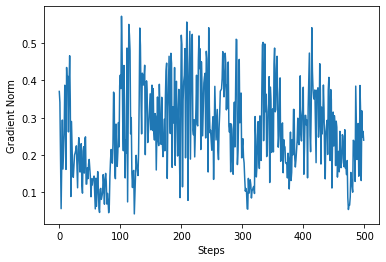

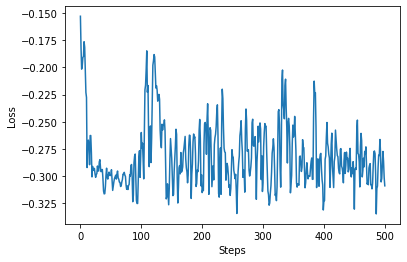

In [ ]:
# plt.plot(range(len(grad_history)), grad_history)
# plt.xlabel('Steps')
# plt.ylabel('Gradient Norm')
# plt.show()

# plt.plot(range(len(loss_history)), loss_history)
# plt.xlabel('Steps')
# plt.ylabel('Loss')
# plt.show()

In [ ]:
# eye = np.eye(4)
# eye[:3,:3] = R.from_quat(best_rot).as_matrix() 
# eye[:3,3] = best_transl
# # eye[:3,:3] = R.align_vectors(target_pts, source_pts)[0].as_matrix()
# draw_registration_result(source, target, eye)


# reg_checker_within_angular_limits(best_rot, [180, max_angle_range, max_angle_range]),
# reg_checker_within_roi(source, roi_params)

In [ ]:
# # Registration checkers
# roi_params = {'corner_x':  -100, 'corner_y':    100, 'corner_z':     100,
#               'dimension_x':200, 'dimension_y': 200, 'dimension_z': 200}

# # Within ROI
# def reg_checker_within_roi(transf_source, roi_params, n_points_exception=1):
#     """
#         args:
#             transf_source: o3d.pointcloud
#             roi_params: Dictionary defining the ROI
#         output:
#             checker: bool, True if a point cloud, e.g. transformed source, falls within roi, else False
    
#     """
#     cropped_pcd = ROI.crop_roi_box(transf_source, roi_params, inverse = True)
#     checker = np.asarray(cropped_pcd.points).shape[0] < n_points_exception
#     return checker

# # Within expected angular range
# def reg_checker_within_angular_limits(reg_trans, max_euler_angles):
#     """
#         args:
#             reg_trans: np.ndarray, 4x4 homogeneous, 3x3 rotation matrix, (4,) quaterion or (3,) euler
#             max_euler_angles: Maximum rotation given in Euler ZYX
#         output:
#             checker: bool, True if transformation angles fall within allowable limits, else False
#     """
#     reg_trans = np.asarray(reg_trans)
#     max_euler_angles = np.abs(np.asarray(max_euler_angles))[:3]
    
#     if reg_trans.shape == (4,):
#         # Quaternion
#         reg_trans_euler = R.from_quat(reg_trans).as_euler('ZYX', degrees=True)
    
#     elif reg_trans.shape == (3,):
#         # Euler angle ZYX
#         reg_trans_euler = reg_trans
    
#     elif reg_trans.shape[0] <= 4 and reg_trans.shape[1] <= 4:
#         # Rotation matrix
#         reg_trans_euler = R.from_matrix(reg_trans[:3,:3]).as_euler('ZYX', degrees=True)
    
#     print(f":: Reg Checker Angle Limits: {reg_trans_euler} within +- {max_euler_angles}")
#     checker = not np.any(np.logical_and(reg_trans_euler > max_euler_angles, reg_trans_euler < -max_euler_angles))
#     return checker
    


In [ ]:
# # Penalty to deviate from orthogonality:
    
# def loss_orthogonality(alpha, R):
#     if R.shape == (4,4):
#         R = R[:3, :3]
#     return alpha * np.linalg.norm(R.T @ R - np.eye(4))

In [ ]:
# def get_mesh_from_pcd(pcd):
    
#     pcd.estimate_normals(
#         search_param = o3d.geometry.KDTreeSearchParamHybrid(20, max_nn=30),
#         fast_normal_computation=False
#     )
    
#     return o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,
#                                                                            o3d.utility.DoubleVector([0.5,5,10,15,20]))


# mesh = get_mesh_from_pcd(source)

# mesh.get_surface_area()

In [ ]:
# draw_registration_result(mesh, target, eye)

In [ ]:
# ########

# import numpy as np

# def gradient_descent(points1, points2, num_iterations, learning_rate):
#     """
#     Maximizes overlap between two surfaces as point clouds using gradient descent.

#     Args:
#         points1 (numpy array): Point cloud of surface 1
#         points2 (numpy array): Point cloud of surface 2
#         num_iterations (int): Number of iterations to run gradient descent
#         learning_rate (float): Learning rate to use for gradient descent

#     Returns:
#         numpy array: Translation vector that maximizes overlap between the two surfaces
#     """
#     # Initialize translation vector to zero
#     translation = np.zeros((3,))

#     # Loop over the specified number of iterations
#     for i in range(num_iterations):
#         # Compute the gradient of the overlap function with respect to the translation vector
#         gradient = compute_gradient(points1, points2, translation)

#         # Update the translation vector using gradient descent
#         translation -= learning_rate * gradient

#     # Return the final translation vector
#     return translation


# def compute_gradient(points1, points2, translation):
#     """
#     Computes the gradient of the overlap function with respect to the translation vector.

#     Args:
#         points1 (numpy array): Point cloud of surface 1
#         points2 (numpy array): Point cloud of surface 2
#         translation (numpy array): Translation vector

#     Returns:
#         numpy array: Gradient of the overlap function with respect to the translation vector
#     """
#     # Compute the transformed point cloud for surface 1
#     transformed_points1 = points1 + translation

#     # Compute the overlap between the two point clouds
#     overlap = compute_overlap(transformed_points1, points2)

#     # Compute the gradient of the overlap function with respect to the translation vector
#     gradient = np.zeros((3,))
#     for i in range(3):
#         delta = np.zeros((3,))
#         delta[i] = 1
#         translation_plus_delta = translation + delta
#         transformed_points1_plus_delta = points1 + translation_plus_delta
#         overlap_plus_delta = compute_overlap(transformed_points1_plus_delta, points2)
#         gradient[i] = (overlap_plus_delta - overlap) / learning_rate

#     # Return the gradient
#     return gradient


# def compute_overlap(points1, points2):
#     """
#     Computes the overlap between two point clouds.

#     Args:
#         points1 (numpy array): Point cloud of surface 1
#         points2 (numpy array): Point cloud of surface 2

#     Returns:
#         float: Overlap between the two point clouds
#     """
#     # Compute the distance between each point in point cloud 1 and the nearest point in point cloud 2
#     distances = np.zeros((points1.shape[0],))
#     for i in range(points1.shape[0]):
#         distances[i] = np.min(np.linalg.norm(points1[i] - points2, axis=1))

#     # Compute the overlap as the sum of the distances
#     overlap = np.sum(distances)

#     # Return the overlap
#     return overlap

In [ ]:
# def quaternion_multiply(quaternion1, quaternion0):
#     w0, x0, y0, z0 = quaternion0
#     w1, x1, y1, z1 = quaternion1
#     return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
#                      x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
#                      -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
#                      x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)


# def daction3(pt, mat):
#     '''derivative of SE(3) transformation of a 3D point'''
#     R = mat[0:3, 0:3]
#     skew_sym_p = np.array([
#         [0.0, -pt[2], pt[1]],
#         [pt[2], 0.0, -pt[0]],
#         [-pt[1], pt[0], 0.0]
#     ])
#     rmat = np.dot(-R, skew_sym_p)
#     return np.array([
#         [R[0, 0], R[0, 1], R[0, 2], rmat[0, 0], rmat[0, 1], rmat[0, 2]],
#         [R[1, 0], R[1, 1], R[1, 2], rmat[1, 0], rmat[1, 1], rmat[1, 2]],
#         [R[2, 0], R[2, 1], R[2, 2], rmat[2, 0], rmat[2, 1], rmat[2, 2]]
#     ])

# daction3(np.array([1,2,3]), np.eye(4))

# # array([0., 0., 0., 1.]) quaternion of the identity matrix
# # r.as_euler('ZYX', degrees=True)

In [ ]:
# source, target, source_pts, target_pts = gen_source_targte()

# voxel_size = 1
# source_ = copy.deepcopy(source).voxel_down_sample(voxel_size)
# target_ = copy.deepcopy(target).voxel_down_sample(voxel_size)

# start_time = time.time()

# gen_icp = ICP_Generalized()
# gen_icp.set_parameters(max_correspondence_distance=50)
# # cCReg = ZeroCenterRegistration()
# # cCReg.set_parameters(gen_icp)

# new_reg_trans, _ = gen_icp.register(copy.deepcopy(source_),
#                                   copy.deepcopy(target_) )

# draw_registration_result(source_, target_, new_reg_trans)

# # print(":: Metric: ", RegistrationMetric.get_overlap_ratio(source_, target_, 3, new_reg_trans))
# print("--- %s seconds ---" % (time.time() - start_time))